# Unsupervised Model & Post-Model Analytics: MDD/PPD Claims

In [126]:
import pandas as pd
# import snowflake.connector
# from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# from prophet import Prophet
import yaml
from statsmodels.tsa.stattools import adfuller
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

cm = sns.light_palette("green", as_cmap=True)
%matplotlib inline

## Load Data

Load data from the four queries below and combine them together for each HCP. 

The results have been saved to the environment so you could load from csv rather than running all queries again.

In [127]:
USE WAREHOUSE COMPUTE_WH; 

No result set received


In [128]:
--Pull TRx for each HCP over year 2017 - 2022
SELECT 
PRIMARY_HCP_NPI,
-- EXTRACT ('year', to_date("DATE_OF_SERVICE")) as "date_year",
-- count(*) as "total_claims",
sum(case when contains(lower("NAME"), 'auvelity') then 1 else 0 end) as "auvelity",
sum(case when contains(lower("NAME"), 'viibryd') then 1 else 0 end) as "viibryd",
sum(case when contains(lower("NAME"), 'fetzima') then 1 else 0 end) as "fetzima",
sum(case when contains(lower("NAME"), 'brintellix') then 1 else 0 end) as "brintellix",
sum(case when contains(lower("NAME"), 'trintellix') then 1 else 0 end) as "trintellix",
sum(case when contains(lower("NAME"), 'rexulti') then 1 else 0 end) as "rexulti",
sum(case when contains(lower("NAME"), 'spravato') then 1 else 0 end) as "spravato",
sum(case when contains(lower("NAME"), 'wellbutrin') then 1 else 0 end) as "wellbutrin"
from 
DEFAULT.COMPILE_BK.MDD_GAUCHER_PPD_COMBINED_CLAIM as "a"
left join DEFAULT.COMPILE_BK.MDD_GAUCHER_PPD_NDCCODE as "b" on "b".NORMALIZED_CODE = "a"."D_PRODUCT_NDC"
left join COMPILE.CONSTELLATION_SOFTWARE.MIGRAINE_GAUCHE_POST_DEPRESSION_PRACTITIONER_DETAILS AS d on "a".primary_hcp_npi = d.identifier
WHERE name ilike any ('%auvelity%', '%viibryd%', '%fetzima%', '%brintellix%', '%trintellix%', '%rexulti%', '%spravato%') AND 
"PRIMARY_HCP_NAME" is not null
group by 1

,PRIMARY_HCP_NPI,auvelity,viibryd,fetzima,brintellix,trintellix,rexulti,spravato,wellbutrin
0,1336186311,0,335,73,0,218,279,0,0
1,1528682804,0,11,0,0,8,61,0,0
2,1164580015,0,30,0,0,11,16,0,0
3,1326005786,0,287,0,0,145,0,0,0
4,1154582765,0,53,209,0,157,7,6,0
...,...,...,...,...,...,...,...,...,...
178591,1750615100,0,1,0,0,0,0,0,0
178592,1477619559,0,1,0,0,0,0,0,0
178593,1760446264,0,0,0,0,1,0,0,0
178594,1225020001,0,2,0,0,0,0,0,0


In [ ]:
# have issue running on datalore, upload from csv as df_yearly_trx
# with total as (SELECT 
# PRIMARY_HCP_NPI,
# EXTRACT ('year', to_date("DATE_OF_SERVICE")) as date_year,
# count(*) as total_claims
# from 
# DEFAULT.COMPILE_BK.MDD_GAUCHER_PPD_COMBINED_CLAIM as "a"
# left join DEFAULT.COMPILE_BK.MDD_GAUCHER_PPD_NDCCODE as "b" on "b".NORMALIZED_CODE = "a"."D_PRODUCT_NDC"
# left join COMPILE.CONSTELLATION_SOFTWARE.MIGRAINE_GAUCHE_POST_DEPRESSION_PRACTITIONER_DETAILS AS d on "a".primary_hcp_npi = d.identifier
# WHERE name ilike any ('%auvelity%', '%viibryd%', '%fetzima%', '%brintellix%', '%trintellix%', '%rexulti%', '%spravato%') AND 
# "PRIMARY_HCP_NAME" is not null
# group by 1,2)
# SELECT 
# 	PRIMARY_HCP_NPI,
# 	SUM(CASE WHEN date_year = '2017' THEN total_claims ELSE 0 END) AS claim_2017,
# 	SUM(CASE WHEN date_year = '2018' THEN total_claims ELSE 0 END) AS claim_2018,
# 	SUM(CASE WHEN date_year = '2019' THEN total_claims ELSE 0 END) AS claim_2019,
# 	SUM(CASE WHEN date_year = '2020' THEN total_claims ELSE 0 END) AS claim_2020,
# 	SUM(CASE WHEN date_year = '2021' THEN total_claims ELSE 0 END) AS claim_2021,
# 	SUM(CASE WHEN date_year = '2022' THEN total_claims ELSE 0 END) AS claim_2022
# FROM total 
# GROUP BY 1;

In [46]:
df_yearly_trx = pd.read_csv('df_yearly_trx.csv', header=0)

In [14]:
--Pull patient level info
SELECT 
PRIMARY_HCP_NPI,
count(DISTINCT D_PATIENT_ID) as "total_patients",
round(avg(datediff(year, PATIENT_BIRTH_YEAR::timestamp, 
                      DATE_OF_SERVICE::timestamp)), 2) AS "avg_age_at_service"                   
from 
DEFAULT.COMPILE_BK.MDD_GAUCHER_PPD_COMBINED_CLAIM as "a"
left join DEFAULT.COMPILE_BK.MDD_GAUCHER_PPD_NDCCODE as "b" on "b".NORMALIZED_CODE = "a"."D_PRODUCT_NDC"
left join COMPILE.CONSTELLATION_SOFTWARE.MIGRAINE_GAUCHE_POST_DEPRESSION_PRACTITIONER_DETAILS AS d on "a".primary_hcp_npi = d.identifier
WHERE name ilike any ('%auvelity%', '%viibryd%', '%fetzima%', '%brintellix%', '%trintellix%', '%rexulti%', '%spravato%') AND 
"PRIMARY_HCP_NAME" is not null
group by 1

,PRIMARY_HCP_NPI,total_patients,avg_age_at_service
0,1710459706,37,50.86
1,1235580754,80,49.88
2,1356816839,13,51.00
3,1417588591,3,50.14
4,1841623402,10,49.95
...,...,...,...
178591,1366879694,1,47.00
178592,1487202099,1,51.00
178593,1013917517,1,48.00
178594,1932435971,1,49.50


In [22]:
df_total_patients.to_csv('df_total_patients.csv', index=False)

In [26]:
--Pull patient level info
--Only two patients out of all miss gender
WITH a AS (
	SELECT DISTINCT 
	PRIMARY_HCP_NPI,
	D_PATIENT_ID,
	PATIENT_GENDER_CODE
	from 
	DEFAULT.COMPILE_BK.MDD_GAUCHER_PPD_COMBINED_CLAIM as "a"
	left join DEFAULT.COMPILE_BK.MDD_GAUCHER_PPD_NDCCODE as "b" on "b".NORMALIZED_CODE = "a"."D_PRODUCT_NDC"
	left join COMPILE.CONSTELLATION_SOFTWARE.MIGRAINE_GAUCHE_POST_DEPRESSION_PRACTITIONER_DETAILS AS d on "a".primary_hcp_npi = d.identifier
	WHERE name ilike any ('%auvelity%', '%viibryd%', '%fetzima%', '%brintellix%', '%trintellix%', '%rexulti%', '%spravato%') AND 
	"PRIMARY_HCP_NAME" is not null
)
SELECT 
PRIMARY_HCP_NPI,
round(100 * sum(CASE WHEN PATIENT_GENDER_CODE = 'F' THEN 1 ELSE 0 END) / count(*), 2) AS "perc_of_female_patients"
FROM a
GROUP BY PRIMARY_HCP_NPI

,PRIMARY_HCP_NPI,perc_of_female_patients
0,1740213982,75.36
1,1326552639,100.00
2,1679771711,93.75
3,1093804577,100.00
4,1740240282,57.14
...,...,...
178591,1083061436,100.00
178592,1205932910,0.00
178593,1558754739,100.00
178594,1467642165,100.00


In [27]:
df_patient_gender.to_csv('df_patient_gender.csv', index=False)

In [30]:
--HCP info
SELECT distinct 
PRIMARY_HCP_NPI,
GENDER_CODE,
YEARS_IN_PRACTICE,
CASE WHEN TWITTER_HANDLE IS NULL THEN 'N' ELSE 'Y' END AS "twitter",
CASE WHEN NUMBER_OF_PUBLICATIONS IS NULL THEN 0 ELSE NUMBER_OF_PUBLICATIONS END AS NUMBER_OF_PUBLICATIONS,
CASE WHEN NUMBER_OF_CLINICAL_TRIALS IS NULL THEN 0 ELSE NUMBER_OF_CLINICAL_TRIALS END AS NUMBER_OF_CLINICAL_TRIALS            
from 
DEFAULT.COMPILE_BK.MDD_GAUCHER_PPD_COMBINED_CLAIM as "a"
left join DEFAULT.COMPILE_BK.MDD_GAUCHER_PPD_NDCCODE as "b" on "b".NORMALIZED_CODE = "a"."D_PRODUCT_NDC"
left join COMPILE.CONSTELLATION_SOFTWARE.MIGRAINE_GAUCHE_POST_DEPRESSION_PRACTITIONER_DETAILS AS d on "a".primary_hcp_npi = d.identifier
WHERE name ilike any ('%auvelity%', '%viibryd%', '%fetzima%', '%brintellix%', '%trintellix%', '%rexulti%', '%spravato%') AND 
"PRIMARY_HCP_NAME" is not null

,PRIMARY_HCP_NPI,GENDER_CODE,YEARS_IN_PRACTICE,twitter,NUMBER_OF_PUBLICATIONS,NUMBER_OF_CLINICAL_TRIALS
0,1578018107,None,NaN,N,0,0
1,1912954660,M,52.0,N,0,1
2,1932655982,F,NaN,N,0,0
3,1043219744,F,NaN,N,0,0
4,1053850214,F,NaN,N,0,0
...,...,...,...,...,...,...
178591,1932355856,F,NaN,N,1,0
178592,1992801617,F,NaN,N,0,0
178593,1497065627,F,NaN,N,0,0
178594,1437184975,None,NaN,N,0,0


In [31]:
df_hcp.to_csv('df_hcp.csv', index=False)

In [48]:
df_trx = pd.read_csv('df_trx.csv', header=0)
df_yearly_trx = pd.read_csv('df_yearly_trx.csv', header=0)
df_total_patients = pd.read_csv('df_total_patients.csv', header=0)
df_patient_gender = pd.read_csv('df_patient_gender.csv', header=0)
df_hcp = pd.read_csv('df_hcp.csv', header=0)

In [49]:
print(df_trx.shape)
print(df_yearly_trx.shape)
print(df_total_patients.shape)
print(df_patient_gender.shape)
print(df_hcp.shape)

(178596, 9)
(178596, 7)
(178596, 3)
(178596, 2)
(178596, 6)


In [50]:
# combine data together 
df = pd.merge(df_trx, df_yearly_trx, on='PRIMARY_HCP_NPI', how='left')
df = pd.merge(df, df_total_patients, on='PRIMARY_HCP_NPI', how='left')
df = pd.merge(df, df_patient_gender, on='PRIMARY_HCP_NPI', how='left')
df = pd.merge(df, df_hcp, on='PRIMARY_HCP_NPI', how='left')

In [51]:
df.head()

,PRIMARY_HCP_NPI,auvelity,viibryd,fetzima,brintellix,trintellix,rexulti,spravato,wellbutrin,CLAIM_2017,...,CLAIM_2021,CLAIM_2022,total_patients,avg_age_at_service,perc_of_female_patients,GENDER_CODE,YEARS_IN_PRACTICE,twitter,NUMBER_OF_PUBLICATIONS,NUMBER_OF_CLINICAL_TRIALS
0,1336186311,0,335,73,0,218,279,0,0,132,...,164,116,115,49.57,75.65,M,38.0,N,0,0
1,1528682804,0,11,0,0,8,61,0,0,0,...,30,48,15,51.58,73.33,NaN,NaN,N,0,0
2,1164580015,0,30,0,0,11,16,0,0,22,...,4,17,11,49.09,45.45,M,33.0,N,0,0
3,1326005786,0,287,0,0,145,0,0,0,22,...,87,53,44,49.79,59.09,M,36.0,N,0,0
4,1154582765,0,53,209,0,157,7,6,0,77,...,71,53,35,49.29,85.71,F,16.0,N,0,0


In [52]:
df.describe()

,PRIMARY_HCP_NPI,auvelity,viibryd,fetzima,brintellix,trintellix,rexulti,spravato,wellbutrin,CLAIM_2017,...,CLAIM_2019,CLAIM_2020,CLAIM_2021,CLAIM_2022,total_patients,avg_age_at_service,perc_of_female_patients,YEARS_IN_PRACTICE,NUMBER_OF_PUBLICATIONS,NUMBER_OF_CLINICAL_TRIALS
count,1.785960e+05,178596.000000,178596.000000,178596.000000,178596.000000,178596.000000,178596.000000,178596.000000,178596.0,178596.000000,...,178596.000000,178596.000000,178596.000000,178596.000000,178596.000000,178596.000000,178596.000000,71384.000000,178596.000000,178596.000000
mean,1.499303e+09,0.003080,9.455839,1.578731,0.065203,15.256691,6.757301,0.680771,0.0,4.439624,...,5.949786,6.348009,6.568255,5.612629,5.283399,49.713593,72.386745,28.252592,0.237799,0.013063
std,2.882828e+08,0.114473,30.695648,10.213751,0.466341,48.882897,32.071159,23.034177,0.0,16.808761,...,20.503610,21.263113,22.632758,20.468064,11.818993,1.494551,35.166461,11.786004,3.286148,0.264732
min,1.003001e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,47.000000,0.000000,1.000000,0.000000,0.000000
25%,1.245717e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,48.640000,50.000000,20.000000,0.000000,0.000000
50%,1.497917e+09,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,49.830000,88.890000,28.000000,0.000000,0.000000
75%,1.740836e+09,0.000000,6.000000,0.000000,0.000000,11.000000,1.000000,0.000000,0.0,2.000000,...,4.000000,4.000000,5.000000,4.000000,5.000000,51.000000,100.000000,37.000000,0.000000,0.000000
max,1.993000e+09,23.000000,3506.000000,935.000000,33.000000,6165.000000,1697.000000,3786.000000,0.0,2054.000000,...,2085.000000,1256.000000,1739.000000,2283.000000,744.000000,52.000000,100.000000,82.000000,279.000000,39.000000


In [60]:
# fill missing HCP gender with Unknown
# fill missing HCP years in practice with mean = 28
# df['YEARS_IN_PRACTICE'].mean()
df['GENDER_CODE'] = df['GENDER_CODE'].fillna('Unkonwn')
df['YEARS_IN_PRACTICE'] = df['YEARS_IN_PRACTICE'].fillna(28)

In [61]:
df.head()

,PRIMARY_HCP_NPI,auvelity,viibryd,fetzima,brintellix,trintellix,rexulti,spravato,wellbutrin,CLAIM_2017,...,CLAIM_2021,CLAIM_2022,total_patients,avg_age_at_service,perc_of_female_patients,GENDER_CODE,YEARS_IN_PRACTICE,twitter,NUMBER_OF_PUBLICATIONS,NUMBER_OF_CLINICAL_TRIALS
0,1336186311,0,335,73,0,218,279,0,0,132,...,164,116,115,49.57,75.65,M,38.0,N,0,0
1,1528682804,0,11,0,0,8,61,0,0,0,...,30,48,15,51.58,73.33,Unkonwn,28.0,N,0,0
2,1164580015,0,30,0,0,11,16,0,0,22,...,4,17,11,49.09,45.45,M,33.0,N,0,0
3,1326005786,0,287,0,0,145,0,0,0,22,...,87,53,44,49.79,59.09,M,36.0,N,0,0
4,1154582765,0,53,209,0,157,7,6,0,77,...,71,53,35,49.29,85.71,F,16.0,N,0,0


In [77]:
# scale num columns
# cat: ['GENDER_CODE',  'twitter']
num_scale = MinMaxScaler()
new_df = df.copy()
new_df = num_scale.fit_transform(new_df[['auvelity', 'viibryd', 'fetzima', 'brintellix',
                'trintellix', 'rexulti', 'spravato', 'wellbutrin', 'CLAIM_2017',
                'CLAIM_2018', 'CLAIM_2019', 'CLAIM_2020', 'CLAIM_2021', 'CLAIM_2022',
                'total_patients', 'avg_age_at_service', 'perc_of_female_patients',
                'YEARS_IN_PRACTICE', 'NUMBER_OF_PUBLICATIONS',
                'NUMBER_OF_CLINICAL_TRIALS']])

## Fit KMeans

### Plot 1 - Cluster estimation

In [80]:
wcss = []
for i in tqdm(range(3,15)):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(new_df)
    wcss.append(kmeans.inertia_)

100%|██████████| 12/12 [00:51<00:00,  4.26s/it]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


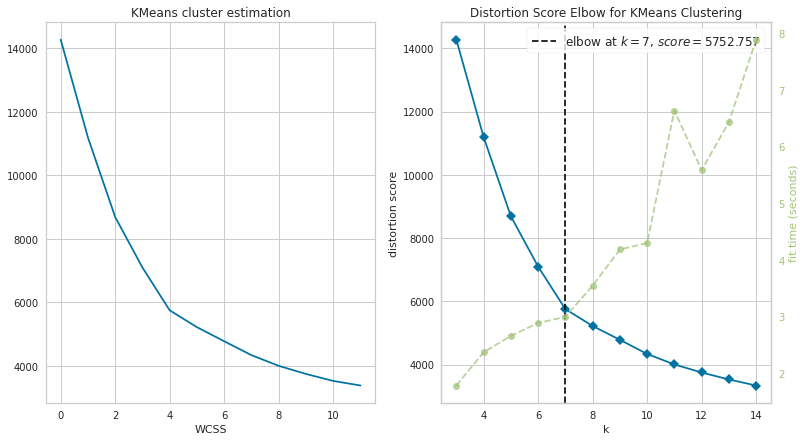

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [81]:
fig, ax = plt.subplots(1,2, figsize=(13, 7))
ax[0].plot(wcss)
ax[0].set_title("KMeans cluster estimation")
ax[0].set_xlabel("K")
ax[0].set_xlabel("WCSS")

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,15))

visualizer.fit(new_df)        # Fit the data to the visualizer
visualizer.show()

In [83]:
#! Build Model

kmeans = KMeans(n_clusters=7)
kmeans.fit(new_df)

KMeans(n_clusters=7)

### Plot 2 - Cluster seperation in lower dimensional space (PCA)

In [85]:
# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(new_df)

# Transfor the scaled data to the new PCA space
X_reduced = pca.transform(new_df)

X_reduced = pd.DataFrame(X_reduced)
X_reduced['cluster_id'] = KMeans(n_clusters=7).fit_predict(new_df).astype(str)

In [86]:
centres_reduced = pca.transform(kmeans.cluster_centers_)
centres_reduced

array([[ 0.71921185, -0.24854279],
 [-0.26884848, 0.41341556],
 [-0.25116169, -0.34920272],
 [ 0.69638802, 0.34347938],
 [ 0.12579314, 0.20419256],
 [-0.23375138, 0.02742703],
 [ 0.14028182, -0.20330846]])

/opt/python/envs/default/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


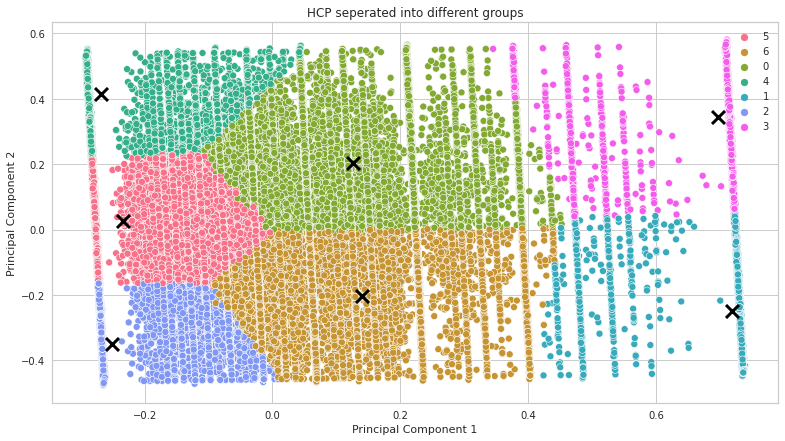

In [88]:
plt.figure(figsize=(13,7))
plt.title("HCP seperated into different groups")
X_reduced = X_reduced.rename({0: "Principal Component 1", 1: "Principal Component 2"}, axis=1)
sns.scatterplot(X_reduced["Principal Component 1"], X_reduced["Principal Component 2"], hue=X_reduced['cluster_id'])
plt.legend(loc='upper right')

plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=3,
            color='black', zorder=10)
plt.show()

In [89]:
df['cluster_id'] = kmeans.fit_predict(new_df)

In [118]:
cluster_df_count = df['cluster_id'].value_counts().reset_index().rename(columns={"index": "cluster_id", "cluster_id": "HCP count"})

### Cluster Statistics

In [119]:
cluster_df_count

,cluster_id,HCP count
0,1,40580
1,6,35684
2,4,26681
3,0,24837
4,2,23803
5,3,14808
6,5,12203


In [100]:
df_num = df.loc[:, ~df.columns.isin(['twitter', 'GENDER_CODE'])]
df_num.set_index('PRIMARY_HCP_NPI', inplace=True)

### Median

In [120]:
cluster_df_median_stats = pd.merge(cluster_df_count, df_num.groupby('cluster_id').median().reset_index(), on='cluster_id')
cluster_df_median_stats.index = cluster_df_median_stats['cluster_id']
cluster_df_median_stats.drop('cluster_id', axis=1, inplace=True)

In [121]:
cluster_df_median_stats = pd.merge(cluster_df_count, df_num.groupby('cluster_id').median().reset_index(), on='cluster_id')
cluster_df_median_stats

,cluster_id,HCP count,auvelity,viibryd,fetzima,brintellix,trintellix,rexulti,spravato,wellbutrin,...,CLAIM_2019,CLAIM_2020,CLAIM_2021,CLAIM_2022,total_patients,avg_age_at_service,perc_of_female_patients,YEARS_IN_PRACTICE,NUMBER_OF_PUBLICATIONS,NUMBER_OF_CLINICAL_TRIALS
0,1,40580,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,...,2.0,2.0,0.0,0.0,2.0,49.57,100.0,28.0,0.0,0.0
1,6,35684,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,2.0,1.0,51.40,100.0,28.0,0.0,0.0
2,4,26681,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,47.67,100.0,28.0,0.0,0.0
3,0,24837,0.0,3.0,0.0,0.0,9.0,1.0,0.0,0.0,...,1.0,4.0,7.0,7.0,4.0,50.67,60.0,28.0,0.0,0.0
4,2,23803,0.0,5.0,0.0,0.0,10.0,0.0,0.0,0.0,...,6.0,3.0,1.0,0.0,5.0,48.84,60.0,28.0,0.0,0.0
5,3,14808,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,51.00,0.0,28.0,0.0,0.0
6,5,12203,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,48.00,0.0,28.0,0.0,0.0


### Mean

In [124]:
cluster_df_mean_stats = pd.merge(cluster_df_count, df_num.groupby('cluster_id').mean().reset_index(), on='cluster_id')
cluster_df_mean_stats.index = cluster_df_mean_stats['cluster_id']
cluster_df_mean_stats.drop('cluster_id', axis=1, inplace=True)

cluster_df_mean_stats.style.background_gradient(cmap=cm)

,HCP count,auvelity,viibryd,fetzima,brintellix,trintellix,rexulti,spravato,wellbutrin,CLAIM_2017,CLAIM_2018,CLAIM_2019,CLAIM_2020,CLAIM_2021,CLAIM_2022,total_patients,avg_age_at_service,perc_of_female_patients,YEARS_IN_PRACTICE,NUMBER_OF_PUBLICATIONS,NUMBER_OF_CLINICAL_TRIALS
cluster_id,,,,,,,,,,,,,,,,,,,,,
1,40580,0.001651,12.305742,2.010005,0.063972,19.664268,7.750271,0.146723,0.000000,4.591597,6.037629,9.111385,9.527132,7.496525,5.178364,5.944110,49.543061,95.680811,27.875037,0.225604,0.012173
6,35684,0.001373,3.019673,0.339060,0.002410,5.319583,2.431090,0.208497,0.000000,0.059522,0.102343,0.396817,1.451323,4.127900,5.183780,2.486212,51.422948,98.460977,27.089396,0.186862,0.008323
4,26681,0.000075,4.097410,0.855290,0.075072,4.972302,1.320003,0.001012,0.000000,5.276414,3.748210,1.554290,0.452869,0.178179,0.111203,2.407443,47.611007,98.115956,29.134178,0.264083,0.014467
0,24837,0.011072,15.450739,1.996779,0.044812,26.975722,14.924629,3.975842,0.000000,2.251359,3.786649,8.164150,13.957362,18.403149,16.816926,9.939204,50.749021,58.942262,27.460523,0.163345,0.010670
2,23803,0.005672,21.882956,4.568794,0.225518,35.611646,15.866781,0.351174,0.000000,15.927068,16.887157,16.976558,12.825022,9.451498,6.445238,11.065832,48.714314,59.246989,29.359072,0.194387,0.011763
3,14808,0.001418,2.096434,0.196178,0.002836,3.351162,0.865951,0.063344,0.000000,0.104268,0.184292,0.545583,1.573879,2.082928,2.086372,1.433279,51.054375,1.177558,27.465289,0.351702,0.017896
5,12203,0.000082,3.003933,0.345817,0.035811,3.034828,0.751291,0.009588,0.000000,2.220356,1.968205,1.826846,0.656150,0.319921,0.189871,1.470704,48.094092,1.827432,29.172007,0.467836,0.028354


### Sum

In [125]:
cluster_df_sum_stats = pd.merge(cluster_df_count, df_num.groupby('cluster_id').sum().reset_index(), on='cluster_id')
cluster_df_sum_stats.index = cluster_df_sum_stats['cluster_id']
cluster_df_sum_stats.drop('cluster_id', axis=1, inplace=True)

cluster_df_sum_stats.style.background_gradient(cmap=cm)

,HCP count,auvelity,viibryd,fetzima,brintellix,trintellix,rexulti,spravato,wellbutrin,CLAIM_2017,CLAIM_2018,CLAIM_2019,CLAIM_2020,CLAIM_2021,CLAIM_2022,total_patients,avg_age_at_service,perc_of_female_patients,YEARS_IN_PRACTICE,NUMBER_OF_PUBLICATIONS,NUMBER_OF_CLINICAL_TRIALS
cluster_id,,,,,,,,,,,,,,,,,,,,,
1,40580,67,499367,81566,2596,797976,314506,5954,0,186327,245007,369740,386611,304209,210138,241212,2010457.420000,3882727.330000,1131169.000000,9155,494
6,35684,49,107754,12099,86,189824,86751,7440,0,2124,3652,14160,51789,147300,184978,88718,1834976.460000,3513481.510000,966658.000000,6668,297
4,26681,2,109323,22820,2003,132666,35219,27,0,140780,100006,41470,12083,4754,2967,64233,1270309.270000,2617831.830000,777329.000000,7046,386
0,24837,275,383750,49594,1113,669996,370683,98748,0,55917,94049,202773,346659,457079,417682,246860,1260453.430000,1463948.970000,682037.000000,4057,265
2,23803,135,520880,108751,5368,847664,377677,8359,0,379112,401965,404093,305274,224974,153416,263400,1159546.820000,1410256.070000,698834.000000,4627,280
3,14808,21,31044,2905,42,49624,12823,938,0,1544,2729,8079,23306,30844,30895,21224,756013.190000,17437.280000,406706.000000,5208,265
5,12203,1,36657,4220,437,37034,9168,117,0,27095,24018,22293,8007,3904,2317,17947,586892.210000,22300.150000,355986.000000,5709,346


In [130]:
cluster_df_sum_stats.shape

(7, 21)